In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
data = pd.read_csv("customer-churn.csv")

In [3]:
#Columns into a list for easy manipulation
data_cols = list(data.columns)

#Get list of all categorical columns
cat = data.select_dtypes('object').columns.to_list()
cat.remove('customerID')
cat.remove('TotalCharges')

In [4]:
#Since there are multiple columns with categorical data, create dummies and create new dataframe
dummy = pd.get_dummies(data[cat])

#Join MonthlyCharges and TotalCharges to new dataframe
data = dummy.join(data[['MonthlyCharges', 'TotalCharges', 'tenure', 'SeniorCitizen']])

In [5]:
#Above, we see TotalCharges has missing values, replace with 0
data['TotalCharges'] = data['TotalCharges'].replace([' '], '0')
#Change data type from object to float64
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'])

In [22]:
#Clean the number of columns for modeling
#Removing all columns with _No in them since _Yes columns can be used.
no_cols = list(filter(lambda x: "_No" in x, data.columns))
no_cols.extend("Churn_Yes")

#Wanted columns for modeling
x_cols = list(set(list(data.columns)) - set(no_cols))
x_cols

['OnlineSecurity_Yes',
 'PaymentMethod_Credit card (automatic)',
 'Contract_Month-to-month',
 'DeviceProtection_Yes',
 'PaymentMethod_Bank transfer (automatic)',
 'gender_Female',
 'MultipleLines_Yes',
 'Dependents_Yes',
 'PaperlessBilling_Yes',
 'PhoneService_Yes',
 'PaymentMethod_Electronic check',
 'OnlineBackup_Yes',
 'gender_Male',
 'StreamingTV_Yes',
 'Contract_One year',
 'SeniorCitizen',
 'StreamingMovies_Yes',
 'InternetService_Fiber optic',
 'InternetService_DSL',
 'TotalCharges',
 'tenure',
 'Partner_Yes',
 'Contract_Two year',
 'PaymentMethod_Mailed check',
 'MonthlyCharges',
 'Churn_Yes',
 'TechSupport_Yes']

Accuracy Score: 0.7988641741599621


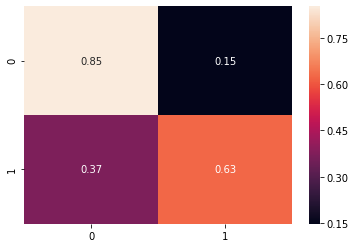

In [21]:
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, accuracy_score 

#Splitting the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(data[x_cols], data['Churn_Yes'], test_size=0.30,
                                                    random_state=50)

#Creating the model instance and fitting the data
lgr = LogisticRegression(solver='lbfgs', max_iter=1500)
lgr.fit(X_train, y_train)
y_pred = lgr.predict(X_test)

#Metrics
cf_matrix = confusion_matrix(y_pred, y_test, normalize='true')
score = accuracy_score(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)
print("Accuracy Score:",score)


Using Cox Proportional Hazards Models
- A regression based model that analyses the covariates of the data to how long a patient lives (In our case, how long a customer stays with us)

In [29]:
#Dimension reduction to feed into CoxPH Fitter
#Must reduce features/reduce collinearity due to matrix inversion problem

x_select = set(data.columns) - set(no_cols)
reduce_col = ['Dependents_Yes', 'Partner_Yes', 'StreamingMovies_Yes', 'StreamingTV_Yes',
              'Device_Protection', 'PaperlessBilling_Yes']
x_select = set(x_select) - set(reduce_col)
x_select

{'Churn_Yes',
 'Contract_Month-to-month',
 'Contract_One year',
 'Contract_Two year',
 'DeviceProtection_Yes',
 'InternetService_DSL',
 'InternetService_Fiber optic',
 'MonthlyCharges',
 'MultipleLines_Yes',
 'OnlineBackup_Yes',
 'OnlineSecurity_Yes',
 'PaymentMethod_Bank transfer (automatic)',
 'PaymentMethod_Credit card (automatic)',
 'PaymentMethod_Electronic check',
 'PaymentMethod_Mailed check',
 'PhoneService_Yes',
 'SeniorCitizen',
 'TechSupport_Yes',
 'TotalCharges',
 'gender_Female',
 'gender_Male',
 'tenure'}

In [33]:
#Dimension reduction to feed into CoxPH Fitter
#Must reduce features/reduce collinearity due to matrix inversion problem
from statsmodels.stats.outliers_influence import variance_inflation_factor


#Used Variance Inflation Factor to find the collinearity between features
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(data[x_select].values, i) for i in range(data[x_select].shape[1])]
vif["features"] = x_select
vif.round(2)

,VIF Factor,features
0,1.52,OnlineSecurity_Yes
1,inf,PaymentMethod_Credit card (automatic)
2,inf,Contract_Month-to-month
3,1.81,DeviceProtection_Yes
4,inf,PaymentMethod_Bank transfer (automatic)
5,inf,gender_Female
6,1.63,MultipleLines_Yes
7,2.08,PhoneService_Yes
8,inf,PaymentMethod_Electronic check
9,1.56,OnlineBackup_Yes


In [40]:
#Removing highly correlated features
high_cor = ["OnlineBackup_Yes","OnlineSecurity_Yes", "DeviceProtection_Yes", "TechSupport_Yes"]
x_sel = set(data.columns) - set(high_cor) - set(no_cols)
x_sel

{'Churn_Yes',
 'Contract_Month-to-month',
 'Contract_One year',
 'Contract_Two year',
 'Dependents_Yes',
 'InternetService_DSL',
 'InternetService_Fiber optic',
 'MonthlyCharges',
 'MultipleLines_Yes',
 'PaperlessBilling_Yes',
 'Partner_Yes',
 'PaymentMethod_Bank transfer (automatic)',
 'PaymentMethod_Credit card (automatic)',
 'PaymentMethod_Electronic check',
 'PaymentMethod_Mailed check',
 'PhoneService_Yes',
 'SeniorCitizen',
 'StreamingMovies_Yes',
 'StreamingTV_Yes',
 'TotalCharges',
 'gender_Female',
 'gender_Male',
 'tenure'}

In [42]:
from lifelines import CoxPHFitter

cph = CoxPHFitter(penalizer=0.1)
cph_train, cph_test = train_test_split(data[x_sel], test_size=0.2)
cph.fit(cph_train, duration_col='tenure', event_col='Churn_Yes')
cph.print_summary()

From the report above, we can see which features increase the likelihood of churning:
    Positive: more likely to cause churn
    Negative: less likely to cause churn
    
Also seen that Concordance is 0.90 which similar to Regression models using accuracy.

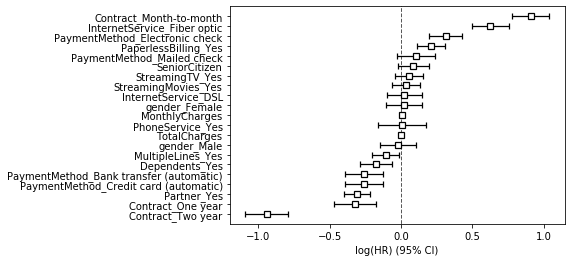

In [43]:
cph.plot()